In [1]:
import cv2
import argparse
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
from keras.models import load_model
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Function to load the images given the folder name
def load_folder(num_samples):
    imgs = []
    files = os.listdir('./MIO-TCD-Localization/train/')
    img_counter = 0
    for img in files:
        # Read the images in grayscale
        img = cv2.cvtColor(cv2.imread('./MIO-TCD-Localization/train/{img}'.format(img=img)), cv2.COLOR_BGR2GRAY)
        # Perform a box blur on the images
        kernel = np.array([[1/9,1/9,1/9], [1/9,1/9,1/9], [1/9,1/9,1/9]])
        img = cv2.filter2D(img, -1, kernel)
        # Resize to reduce computation time
        imgs.append(img)
        img_counter += 1
        if(img_counter==num_samples): break
    return imgs

images = load_folder(1000)

In [3]:
model = load_model('my_model.h5')
enc = LabelEncoder()
classes = ['articulated_truck','background','bicycle','bus','car','motorcycle','non-motorized_vehicle','pedestrian','pickup_truck','single_unit_truck','work_van']
classes = enc.fit_transform(classes)
classes = to_categorical(classes)
for i in range(11):
    print('Encoding:',i, '- Label:', enc.inverse_transform(i))

Encoding: 0 - Label: articulated_truck
Encoding: 1 - Label: background
Encoding: 2 - Label: bicycle
Encoding: 3 - Label: bus
Encoding: 4 - Label: car
Encoding: 5 - Label: motorcycle
Encoding: 6 - Label: non-motorized_vehicle
Encoding: 7 - Label: pedestrian
Encoding: 8 - Label: pickup_truck
Encoding: 9 - Label: single_unit_truck
Encoding: 10 - Label: work_van


In [4]:
def sliding_window(img, stride_x = 30, stride_y = 30, crop_size = 100):
    windows = []
    boxes = []
    for i in range(0, img.shape[0], stride_y):
        for j in range(0, img.shape[1], stride_x):
            windows.append(cv2.resize((img[i:i+crop_size, j:j+crop_size]), (32,32)))
            #windows.append(img[i:i+crop_size, j:j+crop_size])
            boxes.append((i, i+crop_size, j ,j+crop_size))
    return windows, boxes

def get_windows(img):
    windows = []
    coords = []
    big_windows, big_boxes = (sliding_window(img, stride_x = img.shape[1], stride_y = img.shape[0], crop_size = (img.shape[1]+img.shape[0])//2))
    mid_windows, mid_boxes = (sliding_window(img, stride_x = img.shape[1]//2, stride_y = img.shape[0]//2, crop_size = (img.shape[1]+img.shape[0])//4))
    small_windows, small_boxes = (sliding_window(img, stride_x = img.shape[1]//3, stride_y = img.shape[0]//3, crop_size = (img.shape[1]+img.shape[0])//6))
    tiny_windows, tiny_boxes = (sliding_window(img, stride_x = img.shape[1]//6, stride_y = img.shape[0]//6, crop_size = (img.shape[1]+img.shape[0])//12))
    windows.append(big_windows + mid_windows + small_windows)
    coords.append(big_boxes + mid_boxes + small_boxes)
    return windows, coords

def eval_window(window):
    window = cv2.resize(window, (32,32))
    window = np.array(window).reshape(-1,32,32,1)
    return enc.inverse_transform(np.argmax(model.predict(window)))

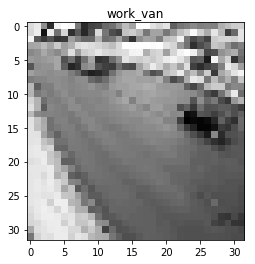

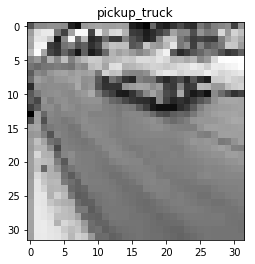

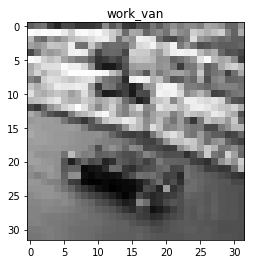

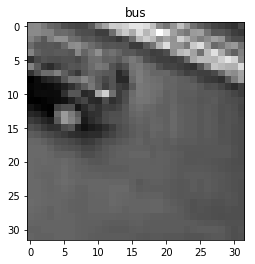

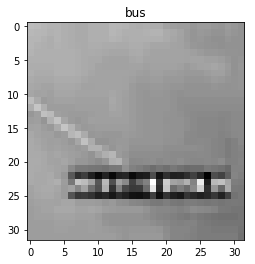

In [5]:
win, coo = get_windows(images[0])
win = np.array(win)
win = win.reshape(-1,32,32)
for window in win:
    clone = images[0].copy()
    if(eval_window(window))!='background':
        plt.figure()
        plt.title(eval_window(window))
        plt.imshow(window, cmap = 'gray')

(14, 32, 32)
(14, 4)
[  0 285   0 285]
[  0 142   0 142]
[  0 142 171 313]
[ 76 171 228 323]
[152 247 228 323]


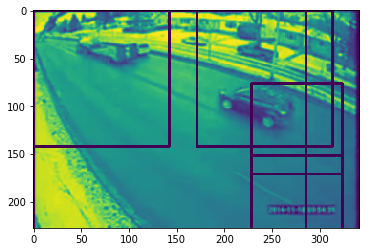

In [6]:
win, coo = get_windows(images[0])
win = np.array(win)
win = win.reshape(-1,32,32)
coo = np.array(coo)
coo = coo.reshape(win.shape[0],-1)
print(win.shape)
print(coo.shape)
clone = images[0].copy()
for i, window in enumerate (win):
    if(eval_window(window))!='background':
        xi, xf, yi, yf = coo[i]
        print(coo[i])
        clone = cv2.rectangle(clone, (yi, xi), (yf, xf), (0, 0, 0), 2)
plt.imshow(clone)

In [7]:
def test_case(num):
    plt.figure()
    win, coo = get_windows(images[num])
    win = np.array(win)
    win = win.reshape(-1,32,32)
    coo = np.array(coo)
    coo = coo.reshape(win.shape[0],-1)
    clone = images[num].copy()
    for i, window in enumerate (win):
        if(eval_window(window))!='background':
            xi, xf, yi, yf = coo[i]
            clone = cv2.rectangle(clone, (yi, xi), (yf, xf), (0, 0, 0), 2)
#             plt.figure()
#             plt.title(eval_window(window))
#             plt.imshow(window, cmap = 'gray')
    plt.figure()
    plt.imshow(clone, cmap = 'gray')
    
def get_pred(num):
    coords = []
    win, coo = get_windows(images[num])
    win = np.array(win)
    win = win.reshape(-1,32,32)
    coo = np.array(coo)
    coo = coo.reshape(win.shape[0],-1)
    for i, window in enumerate (win):
        if(eval_window(window))!='background':
            coords.append(coo[i])
    return coords

<Figure size 432x288 with 0 Axes>

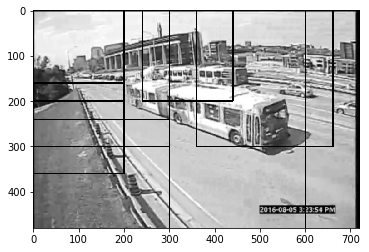

<Figure size 432x288 with 0 Axes>

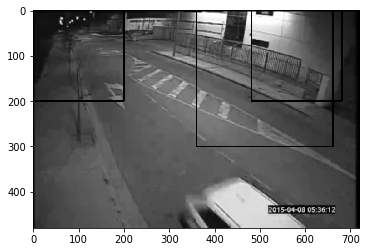

<Figure size 432x288 with 0 Axes>

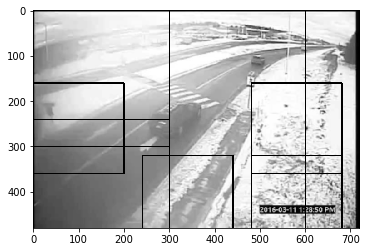

<Figure size 432x288 with 0 Axes>

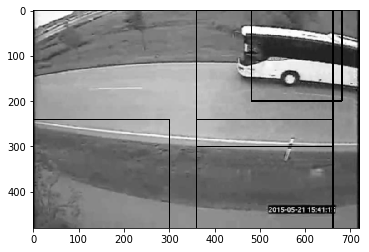

<Figure size 432x288 with 0 Axes>

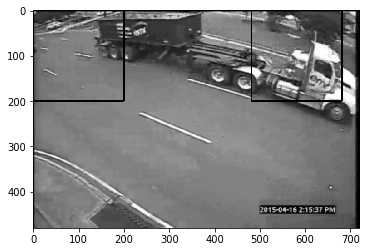

<Figure size 432x288 with 0 Axes>

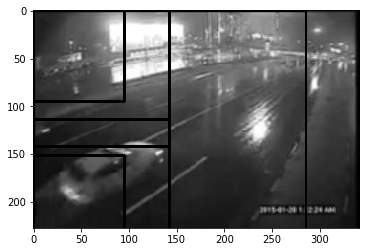

<Figure size 432x288 with 0 Axes>

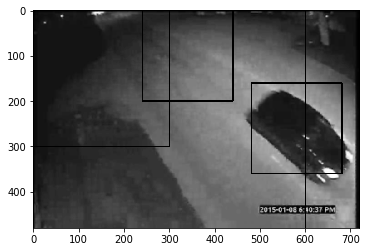

<Figure size 432x288 with 0 Axes>

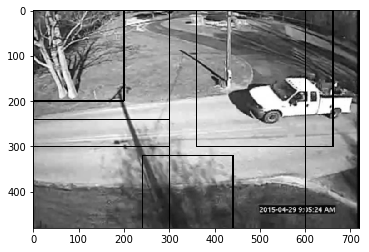

<Figure size 432x288 with 0 Axes>

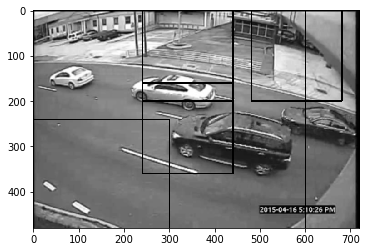

In [8]:
for i in range(1,10):
    test_case(i)

In [9]:
# Get train data
data = pd.read_csv('MIO-TCD-Localization/gt_train.csv', header = None)
data.columns = ['image_id', 'class','xi', 'yi', 'xf', 'yf']

In [10]:
def get_ground_truth(image_num):
    new_data = data[data['image_id'] == image_num]
    new_data = new_data.drop(columns = ['image_id'])
    objects = []
    for i in range(new_data.shape[0]):
        objects.append(new_data.iloc[i].values)
    return pd.DataFrame(objects)
get_ground_truth(0)

,0,1,2,3,4
0,pickup_truck,213,34,255,50
1,car,194,78,273,122
2,car,155,27,183,35
3,articulated_truck,43,25,109,55
4,car,106,32,124,45


In [11]:
def display_gt(image_num):
    clone = images[image_num].copy()
    objects = get_ground_truth(image_num)
    classes = objects.iloc[:,0].values
    xis = objects.iloc[:,1].values
    yis = objects.iloc[:,2].values
    xfs = objects.iloc[:,3].values
    yfs = objects.iloc[:,4].values
    for i in range(len(classes)):
        xi = int(xis[i])
        xf = int(xfs[i])
        yi = int(yis[i])
        yf = int(yfs[i])
        clone = cv2.rectangle(clone, (xi, yi), (xf, yf), (0, 0, 0), 2)
    plt.imshow(clone, cmap = 'gray')
    
def get_gt(image_num):
    objects = get_ground_truth(image_num)
#     classes = objects.iloc[:,0].values
    rows = objects.iloc[:,1:].values
    #print(classes, xis, yis, xfs, yfs)
    return rows
get_gt(0)

array([[213,  34, 255,  50],
       [194,  78, 273, 122],
       [155,  27, 183,  35],
       [ 43,  25, 109,  55],
       [106,  32, 124,  45]], dtype=int64)

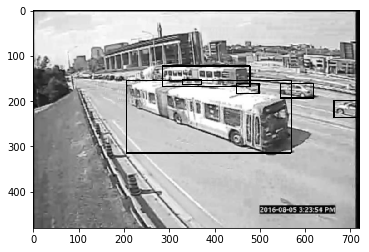

In [12]:
display_gt(1)

In [13]:
def calculate_dice(true_box, pred_box):
    xi = max(true_box[0], pred_box[0])
    yi = max(true_box[1], pred_box[1])
    xf = min(true_box[2], pred_box[2])
    yf = min(true_box[3], pred_box[3])
    tp = max(0, xf - xi + 1) * max(0, yf - yi + 1)
    true_box = (true_box[2] - true_box[0] + 1) * (true_box[3] - true_box[1] + 1)
    pred_box = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
    temp = tp / float(true_box + pred_box - tp)
    
    dice_coefficient = (2 * temp)/(temp + 1)
    
    return dice_coefficient

In [14]:
labels = get_gt(1)
dice_scores = []
points = []
for i in range(len(labels)):
    points = labels[i]
    for co in coo:
        x,y,xx,yy = co
        guess = np.asarray(co)
        score = calculate_dice(points, guess)
        dice_scores.append(score)
# print(dice_scores)
correct_dice = np.array(dice_scores)
correct_dice = correct_dice[correct_dice>0]
# print(correct_dice)
print('Total Objects:', len(classes))
print('True Positives:', len(correct_dice))
print('Objects Detected:', len(dice_scores))
print('Average DICE', np.mean(correct_dice))

Total Objects: 11
True Positives: 3
Objects Detected: 84
Average DICE 0.06830311130544064


In [25]:
def get_img_dice(imge_num):
    labels = get_gt(imge_num)
    dice_scores = []
    points = []
    coo = get_pred(imge_num)
    for i in range(len(labels)):
        points = labels[i]
        for co in coo:
            x,y,xx,yy = co
            guess = np.asarray(co)
            score = calculate_dice(points, guess)
            dice_scores.append(score)
    # print(dice_scores)
    correct_dice = np.array(dice_scores)
    correct_dice = correct_dice[correct_dice>0]
    # print(correct_dice)
#     print('Total Objects:', len(classes))
#     print('True Positives:', len(correct_dice))
#     print('Objects Detected:', len(dice_scores))
    dice = np.mean(correct_dice)
    dice = np.nan_to_num(dice)
#     print('Average DICE', dice)
    return dice

Mean DICE coeef. 0.05122165486336556


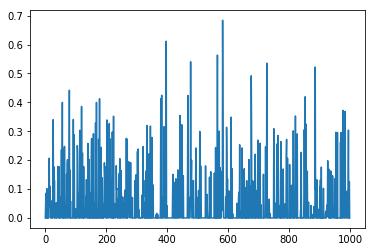

Validation set 1 DICE score: 0.06406105800853515
Validation set 2 DICE score: 0.05676242029743019
Validation set 3 DICE score: 0.047940293807841566
Validation set 4 DICE score: 0.04125240495804431
Validation set 5 DICE score: 0.04609209724497654


In [27]:
k = 5
size = 200
test = load_folder(k*size)
fold_1 = test[:size]
fold_2 = test[size:2*size]
fold_3 = test[2*size:3*size]
fold_4 = test[3*size:4*size]
fold_5 = test[4*size:]

dice_fold_1 = []
dice_fold_2 = []
dice_fold_3 = []
dice_fold_4 = []
dice_fold_5 = []

for i in range(size):
    dice_fold_1.append(get_img_dice(i))

for i in range(size, 2*size):
    dice_fold_2.append(get_img_dice(i))
    
for i in range(2*size,3*size):
    dice_fold_3.append(get_img_dice(i))
    
for i in range(3*size, 4*size):
    dice_fold_4.append(get_img_dice(i))

for i in range(4*size,5*size):
    dice_fold_5.append(get_img_dice(i))

plt.plot(dice_fold_1+dice_fold_2+dice_fold_3+dice_fold_4+dice_fold_5)
print('Mean DICE coeff.',np.mean(np.array(dice_fold_1+dice_fold_2+dice_fold_3+dice_fold_4+dice_fold_5)))
plt.show()
    
dice_fold_1 = np.array(dice_fold_1)
dice_fold_2 = np.array(dice_fold_2)
dice_fold_3 = np.array(dice_fold_3)
dice_fold_4 = np.array(dice_fold_4)
dice_fold_5 = np.array(dice_fold_5)

print('Validation set 1 DICE score:', np.mean(dice_fold_1))
print('Validation set 2 DICE score:', np.mean(dice_fold_2))
print('Validation set 3 DICE score:', np.mean(dice_fold_3))
print('Validation set 4 DICE score:', np.mean(dice_fold_4))
print('Validation set 5 DICE score:', np.mean(dice_fold_5))

In [28]:
print('St. Deviations of DICE coeff.',np.std(np.array(dice_fold_1+dice_fold_2+dice_fold_3+dice_fold_4+dice_fold_5)))

St. Deviations of DICE coeff. 0.22689809297221103
